<a href="https://colab.research.google.com/github/economer/NHANES/blob/master/simple_abm_June_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Design
- **Research Design and Methods**:

1- The model being used simulates changes in diet quality for adults aged 18-64 in Canada in 2015, in response to 17 different forms of Basic Income (BI) that vary by model, benefit levels, and reduction rates.

2- This model is based on data from the 2015 Canadian Community Health Survey-Nutrition, a nationally representative survey.

3- Agents in the model are characterized by attributes such as age, sex, ethnicity, household income, diet quality, food spending, and energy intake.

4- An agent’s income determines their food budget, which they spend bi-weekly on 10 categories of food that differ in price.

5- The amount an agent spends on each food category determines their overall diet quality.

6- The researchers will conduct 17 policy experiments introducing 17 different forms of BI.

7- At each bi-weekly time step, agents calculate their total available income, determine their food budget, and adjust their food spending until it is within 10% of their new, higher food budget.

8- Agents' diet quality evolves over time with changes in their food spending, resulting in a new distribution of diet quality by income at the population level.

9- Outcomes will be compared to the baseline scenario and across the 17 policy experiments.

- **Attributes of Agents**:

1- Each agent is assigned socio-demographic characteristics, which are key determinants of diet quality.

2- Agents are assigned a food budget based on the proportion of their annual household net income spent on food.

3- Diet quality, energy intake, and food spending are assigned to agents based on the Healthy Eating Food Index-2019 and 2015 CCHS-Nutrition data.

4- Intake data are matched to average inflation-adjusted food prices for the 10 food categories to determine food spending.

5- Energy intake is held constant in the model because most adults maintain relatively constant energy intake over time.

6- Policy Experiments and Food Selection Decision Rules:

7- Agents’ food budget is determined by their income.

8- The model is initialized by calibrating each agent’s diet quality to data in the 2015 CCHS-Nutrition.

9- 17 policy experiments are conducted by implementing one of 17 different forms of a BI.

10- At each bi-weekly time step, agents receive their regular income and a BI payment, calculate their new higher food budget, and adjust their food spending if necessary.

11- Agents select one or more food categories to adjust based on a probability function that includes price, income elasticity of demand, agents' current consumption, mean consumption of adults at the agent's new higher income level, and random components.
12- Agents cease to adjust their spending once their food spending is within 10% of their new higher food budget.

- **Appendix 2 Components of the Probability Function:**

The probability function that governs food spending at each step after receiving a Basic Income includes mean prices of items in the 10 food categories, income elasticity of demand for these categories, agents’ current mean consumption of each category, mean consumption of each category by individuals at the agents’ new higher income level, random components, energy intake, food spending at prior step, and food budget.

# Model
- This version works the best so far.
- The bugs are fixed and we can see chnages in the distribution of diet quality
- It needs to be expanded
- It requires higher levels of complexity
- Questions:
 - should we add tax (how)
 - Do we need to use probability function or is it better to use AIDS?

## Import Dependecies

In [ ]:
!pip install mesa --quiet
import random
import math
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.datacollection import DataCollector
from plotnine import ggplot, aes, geom_density, geom_vline, facet_wrap, theme_bw
from scipy.optimize import minimize
!pip install piplyr==0.0.8 --quiet
import pandas as pd
from piplyr.main import piplyr
from scipy.optimize import minimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.9 MB/s eta 0:00:00


## Global variables



In [ ]:
# Global for Citizen

# Defining global constant values which are used in calculations throughout the script
MEAN_INCOME = 67000  # Average income of citizens
STD_DEV_INCOME = 40000  # Standard deviation of the income

MEDIAN_RATE = 4
MIN_INCOME = 40000
BASIC_INCOME = 7300
TAX_RATE = 0.0

# Global for FoodAgent

FOOD_CATEGORIES = ['grains', 'fveg', 'protein','milk','fats']
ENERGY_CONTENT = [3.5, 0.5, 4, 0.6, 9]
DIET_QUALITY_WEIGHTS = [0.2, 0.4, 0.3, 0.3, 0.05]

FOOD_PRICES = [1.5, 2.0, 2.5]

MEAN_FVEG  = 301.7
STD_DEV_FVEG = 337.4

MEAN_PROTEIN = 291
STD_DEV_PROTEIN = 254

MEAN_GRAINS = 340
STD_DEV_GRAINS = 291


MEAN_MILK = 158
STD_DEV_MILK = 236

MEAN_FATS = 17.0
STD_DEV_FATS = 30.0

MEAN_SUGARS = 232
STD_DEV_SUGARS = 155


MEAN_FVEG_KCAL  = 248.1
STD_DEV_FVEG_KCAL = 255.3

MEAN_PROTEIN_KCAL = 569.5
STD_DEV_PROTEIN_KCAL = 466.1

MEAN_GRAINS_KCAL = 762
STD_DEV_GRAINS_KCAL = 598


MEAN_MILK_KCAL = 169.3
STD_DEV_MILK_KCAL = 223.3

MEAN_FATS_KCAL = 55.1
STD_DEV_FATS_KCAL = 105.8

SUR_COEFF = {
    'grains': {
        'intercept': 656.3599102,
        'gram_fveg': 0.0960991,
        'gram_protein': -0.0684600,
        'gram_milk': 0.1035170,
        'gram_fats': -1.1291926,
        'kcal_fveg': -0.1440327,
        'kcal_protein': -0.1271648,
        'kcal_milk': -0.0662258,
        'kcal_fats': 0.2028143,
        'income': 0.0378902
    },
    'fveg': {
        'intercept': 32.5274243,
        'gram_grains': 0.1118074,
        'gram_protein': 0.2198393,
        'gram_milk': 0.2953377,
        'gram_fats': 1.7092884,
        'kcal_grains': -0.0550778,
        'kcal_protein': -0.0333032,
        'kcal_milk': -0.1015065,
        'kcal_fats': 0.1003581,
        'income': 0.1870400
    },
    'protein': {
        'intercept': 502.5269571,
        'gram_grains': -0.1229473,
        'gram_fveg': 0.0683462,
        'gram_milk': 0.0084600,
        'gram_fats': 0.9348048,
        'kcal_fveg': 0.0406137,
        'kcal_grains': -0.0391789,
        'kcal_milk': -0.0473292,
        'kcal_fats': 0.0181420,
        'income': 0.0297413
    },
    'milk': {
        'intercept': 166.2357352,
        'gram_grains': -0.1338204,
        'gram_fveg': 0.1207012,
        'gram_protein': -0.0073861,
        'gram_fats': 0.0098991,
        'kcal_fveg': -0.0199169,
        'kcal_grains': 0.0960872,
        'kcal_protein': -0.0123012,
        'kcal_fats': 0.0226110,
        'income': -0.0567115
    },
    'fats': {
        'intercept': 2.6305100,
        'gram_grains': -0.0124758,
        'gram_fveg': 0.0144748,
        'gram_protein': -0.0045379,
        'gram_milk': -0.0126353,
        'kcal_fveg': 0.0027346,
        'kcal_grains': 0.0035836,
        'kcal_protein': 0.0133722,
        'kcal_milk': 0.0183320,
        'income': 0.0079260
    }
}


## Citizen Agent - the model works

In [ ]:

# Define Citizen class which inherits from Agent class
class Citizen(Agent):
    # Initialization function for the Citizen class
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.income = self.initialize_income()  # This is annual income
        self.basic_income_amount = 0

        # initialize foods amounts
        self.gram_grains = self.model.food_agent.gram_grains
        self.gram_fveg = self.model.food_agent.gram_fveg
        self.gram_protein = self.model.food_agent.gram_protein
        self.gram_milk = self.model.food_agent.gram_milk
        self.gram_fats = self.model.food_agent.gram_fats

        # initalize foods energy
        self.kcal_grains = self.model.food_agent.kcal_grains
        self.kcal_fveg = self.model.food_agent.kcal_fveg
        self.kcal_protein = self.model.food_agent.kcal_protein
        self.kcal_milk = self.model.food_agent.kcal_milk
        self.kcal_fats = self.model.food_agent.kcal_fats

        # initialize food consumption based on calculate food consumption
        self.food_consumption = self.calculate_food_consumption()

        # initialize energy intake based on initialize_energy_intake
        self.energy_intake = self.get_energy_intake()

        # initialize diet quality based on diet_quality_score
        self.diet_quality_scores = self.get_diet_quality_score()

    # Method to initialize income
    def initialize_income(self):
        mu = np.log(MEAN_INCOME ** 2 / np.sqrt(MEAN_INCOME ** 2 + STD_DEV_INCOME ** 2))
        sigma = np.sqrt(np.log(1 + (STD_DEV_INCOME ** 2 / MEAN_INCOME ** 2)))
        self.income = round(np.random.lognormal(mu, sigma), 0)
        return self.income  # return annual income

    # Method to calculate food consumption based on a Seemingly Unrelated Regression (SUR) model
    # Here, we are applying the SUR model for each food category (grains, fruit and vegetables, protein, milk, fats)
    # Each food category's gram is calculated based on the SUR coefficients, which considers the current grams and kcals
    # of other food categories and the citizen's income

    # Grains
    def calculate_grains_consumption(self):
        self.gram_grains = self.model.food_agent.SUR_coefficients['grains']['intercept'] + \
                          self.model.food_agent.SUR_coefficients['grains']['gram_fveg'] * self.gram_fveg + \
                          self.model.food_agent.SUR_coefficients['grains']['gram_protein'] * self.gram_protein + \
                          self.model.food_agent.SUR_coefficients['grains']['gram_milk'] * self.gram_milk + \
                          self.model.food_agent.SUR_coefficients['grains']['gram_fats'] * self.gram_fats + \
                          self.model.food_agent.SUR_coefficients['grains']['kcal_fveg'] * self.kcal_fveg + \
                          self.model.food_agent.SUR_coefficients['grains']['kcal_protein'] * self.kcal_protein + \
                          self.model.food_agent.SUR_coefficients['grains']['kcal_milk'] * self.kcal_milk + \
                          self.model.food_agent.SUR_coefficients['grains']['kcal_fats'] * self.kcal_fats + \
                          self.model.food_agent.SUR_coefficients['grains']['income'] * self.income/365
        return self.gram_grains

    # Fruits and Veg
    def calculate_fveg_consumption(self):
        self.gram_fveg = self.model.food_agent.SUR_coefficients['fveg']['intercept'] + \
                        self.model.food_agent.SUR_coefficients['fveg']['gram_grains'] * self.gram_grains + \
                        self.model.food_agent.SUR_coefficients['fveg']['gram_protein'] * self.gram_protein + \
                        self.model.food_agent.SUR_coefficients['fveg']['gram_milk'] * self.gram_milk + \
                        self.model.food_agent.SUR_coefficients['fveg']['gram_fats'] * self.gram_fats + \
                        self.model.food_agent.SUR_coefficients['fveg']['kcal_grains'] * self.kcal_grains + \
                        self.model.food_agent.SUR_coefficients['fveg']['kcal_protein'] * self.kcal_protein + \
                        self.model.food_agent.SUR_coefficients['fveg']['kcal_milk'] * self.kcal_milk + \
                        self.model.food_agent.SUR_coefficients['fveg']['kcal_fats'] * self.kcal_fats + \
                        self.model.food_agent.SUR_coefficients['fveg']['income'] * self.income/365
        return self.gram_fveg

    # Protein
    def calculate_protein_consumption(self):
        self.gram_protein = self.model.food_agent.SUR_coefficients['protein']['intercept'] + \
                            self.model.food_agent.SUR_coefficients['protein']['gram_fveg'] * self.gram_fveg + \
                            self.model.food_agent.SUR_coefficients['protein']['gram_grains'] * self.gram_grains + \
                            self.model.food_agent.SUR_coefficients['protein']['gram_milk'] * self.gram_milk + \
                            self.model.food_agent.SUR_coefficients['protein']['gram_fats'] * self.gram_fats + \
                            self.model.food_agent.SUR_coefficients['protein']['kcal_fveg'] * self.kcal_fveg + \
                            self.model.food_agent.SUR_coefficients['protein']['kcal_grains'] * self.kcal_grains + \
                            self.model.food_agent.SUR_coefficients['protein']['kcal_milk'] * self.kcal_milk + \
                            self.model.food_agent.SUR_coefficients['protein']['kcal_fats'] * self.kcal_fats + \
                            self.model.food_agent.SUR_coefficients['protein']['income'] * self.income/365
        return self.gram_protein

    # Milk
    def calculate_milk_consumption(self):
        self.gram_milk = self.model.food_agent.SUR_coefficients['milk']['intercept'] + \
                        self.model.food_agent.SUR_coefficients['milk']['gram_fveg'] * self.gram_fveg + \
                        self.model.food_agent.SUR_coefficients['milk']['gram_grains'] * self.gram_grains + \
                        self.model.food_agent.SUR_coefficients['milk']['gram_protein'] * self.gram_protein + \
                        self.model.food_agent.SUR_coefficients['milk']['gram_fats'] * self.gram_fats + \
                        self.model.food_agent.SUR_coefficients['milk']['kcal_fveg'] * self.kcal_fveg + \
                        self.model.food_agent.SUR_coefficients['milk']['kcal_grains'] * self.kcal_grains + \
                        self.model.food_agent.SUR_coefficients['milk']['kcal_protein'] * self.kcal_protein + \
                        self.model.food_agent.SUR_coefficients['milk']['kcal_fats'] * self.kcal_fats + \
                        self.model.food_agent.SUR_coefficients['milk']['income'] * self.income/365
        return self.gram_milk

    # Fats
    def calculate_fats_consumption(self):
        self.gram_fats = self.model.food_agent.SUR_coefficients['fats']['intercept'] + \
                        self.model.food_agent.SUR_coefficients['fats']['gram_fveg'] * self.gram_fveg + \
                        self.model.food_agent.SUR_coefficients['fats']['gram_grains'] * self.gram_grains + \
                        self.model.food_agent.SUR_coefficients['fats']['gram_protein'] * self.gram_protein + \
                        self.model.food_agent.SUR_coefficients['fats']['gram_milk'] * self.gram_milk + \
                        self.model.food_agent.SUR_coefficients['fats']['kcal_fveg'] * self.kcal_fveg + \
                        self.model.food_agent.SUR_coefficients['fats']['kcal_grains'] * self.kcal_grains + \
                        self.model.food_agent.SUR_coefficients['fats']['kcal_protein'] * self.kcal_protein + \
                        self.model.food_agent.SUR_coefficients['fats']['kcal_milk'] * self.kcal_milk + \
                        self.model.food_agent.SUR_coefficients['fats']['income'] * self.income/365
        return max(0,self.gram_fats)

    # Make a dictionary of foods amounts
    def calculate_food_consumption(self):
        return {'grains': self.calculate_grains_consumption(),
                'fveg': self.calculate_fveg_consumption(),
                'protein': self.calculate_protein_consumption(),
                'milk': self.calculate_milk_consumption(),
                'fats': self.calculate_fats_consumption()
                }


    # initalize energy intake that is sum of gram of food consumued in each category times energy content of that category
    def get_energy_intake(self):
        self.energy_intake = sum(
            self.food_consumption[category] * self.model.food_agent.energy_content[category]
                    for category in self.model.food_agent.food_categories
            )
        return self.energy_intake

   # initalize energy intake that is sum of gram of food consumued in each category times weight assigend to that category
    def get_diet_quality_score(self):
        self.diet_quality_scores = sum(
            self.food_consumption[category] * self.model.food_agent.diet_quality_weights[category]
            for category in self.model.food_agent.food_categories
            )
        return self.diet_quality_scores

   # in each step (>0), income, food consumption, energy intake and diet quality scores are updated based on modify_ methods
    def step(self):
        self.modify_income()
        if self.income < MIN_INCOME:
            self.modify_food_consumption()
            self.modify_energy_intake()
            self.modify_diet_quality_score()




    # this is how income is modified, the basic_income_amount and tax amounts for each day are derived from Government agent
    # then self.daily_income is update ==> self.daily_income = daily_income + basic_income - tax
    # here tax is set ot be zero
    def modify_income(self):
        self.basic_income_amount = self.model.government_agent.calculate_basic_income(self)
        tax = self.model.government_agent.collect_taxes(self)
        self.income += (self.basic_income_amount - tax)
        return self.income  # Update the annual income

    # Method to modify food consumption. If the income has increased, the food consumption is recalculated
    def modify_food_consumption(self):
        self.food_consumption = self.calculate_food_consumption()

    # Method to modify the energy intake based on the updated food consumption
    def modify_energy_intake(self):
        self.energy_intake = self.get_energy_intake()

    # Method to modify the diet quality score based on the updated food consumption
    def modify_diet_quality_score(self):
        self.diet_quality_scores = self.get_diet_quality_score()



## Government Agent
- Government pays the basic income by considering agents income

In [ ]:


# Define the Government class, which inherits from the Agent class
class Government(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # Initialize median income of all citizens to 0
        self.median_income = 0
        # Initialize tax of all citizens to 0
        self.tax_collected = 0
        self.tax_amount = {}  # Stores tax for each citizen
        self.basic_income = {}  # Stores basic income for each citizen

    # Function to perform a step in the simulation for the Government agent
    def step(self):
        # Calculate median income of all Citizen agents
        incomes = [a.income for a in self.model.schedule.agents if isinstance(a, Citizen)]
        if incomes:
            self.median_income = np.median(incomes)

        # For each Citizen agent, calculate their basic income and collect their taxes
        for a in self.model.schedule.agents:
            if isinstance(a, Citizen):
                self.calculate_basic_income(a)
                self.collect_taxes(a)

    # Function to calculate the basic income for a specific Citizen agent
    def calculate_basic_income(self, citizen):
        # If the citizen's income is less than a specified rate of the median income
        if citizen.income < MIN_INCOME:
            # Calculate the amount of basic income they will receive and store it in the dictionary
            #self.basic_income[citizen.unique_id] = 7300

            self.basic_income[citizen.unique_id] =  (1-(citizen.income/MIN_INCOME))*BASIC_INCOME/365
            # Return the amount of basic income for the citizen
            return self.basic_income[citizen.unique_id]
        else:
            # If the citizen's income is not less than the specified rate of the median income, they receive no basic income
            return 0

    # Function to calculate the tax for a specific Citizen agent
    def collect_taxes(self, citizen):
        # If the citizen's income is greater or equal to 110% of the median income
        if citizen.income >= 1.1*self.median_income:
            # Calculate the amount of tax they need to pay and store it in the dictionary
            self.tax_amount[citizen.unique_id] = citizen.income * TAX_RATE  # Assuming a tax rate of 20%
            # Return the amount of tax for the citizen
            return self.tax_amount[citizen.unique_id]
        else:
            # If the citizen's income is less than 110% of the median income, they pay no tax
            return 0



## Food Agent
- there are 3 types of foods and their price are determined outside
- the foods are chosen based on a probability function
- Citizen agent choose the foods

In [ ]:


# Define the FoodAgent class which inherits from the Agent class
class FoodAgent(Agent):
    # Initialization function for the FoodAgent class
    def __init__(self, unique_id, model):
        # Call the initialization function of the parent class (Agent)
        super().__init__(unique_id, model)

        self.rng = np.random.RandomState(unique_id)

        # Initialize the food categories
        self.food_categories = FOOD_CATEGORIES

        # Initialize the amount of each food category using zero-inflated distributions
        self.gram_fveg = self.initialize_fveg_amounts()
        self.gram_protein = self.initialize_protein_amounts()
        self.gram_grains = self.initialize_grains_amounts()
        self.gram_milk = self.initialize_milk_amounts()
        self.gram_fats = self.initialize_fats_amounts()

        # Initialize the energy content (in kilocalories) of each food category using zero-inflated distributions
        self.kcal_fveg = self.initialize_fveg_kcal()
        self.kcal_protein = self.initialize_protein_kcal()
        self.kcal_grains = self.initialize_grains_kcal()
        self.kcal_milk = self.initialize_milk_kcal()
        self.kcal_fats = self.initialize_fats_kcal()

        # Initialize dictionaries for price, energy content, and diet quality weights
        self.price = {}
        self.energy_content = {}
        self.diet_quality_weights = {}

        # Call the methods to fill these dictionaries
        self.initialize_price()
        self.initialize_energy_content()
        self.calculate_diet_quality()

        # Define the SUR model coefficients for each food category
        # These coefficients are used to model consumer food choices based on different factors
        # Such as price, energy content, diet quality and income

        self.SUR_coefficients = SUR_COEFF
    #Define a function for zero-inflated distributions
    # This distribution is commonly used when the data has an excessive number of zeros
    # 'mean' is the average value, 'std_dev' is the standard deviation, and 'zero_prob' is the probability of getting a zero
    def zero_inflated(self, mean, std_dev, zero_prob=0.3):
        if self.rng.random() < zero_prob:
            return 0
        else:
            mu = np.log(mean ** 2 / np.sqrt(mean ** 2 + std_dev ** 2))
            sigma = np.sqrt(np.log(1 + (std_dev ** 2 / mean ** 2)))
            return round(self.rng.lognormal(mu, sigma), 0)

    # The following are initialization functions for the amount (in grams) of each food category
    # They call the zero_inflated function using the mean and standard deviation specific to each category

    def initialize_fveg_amounts(self):
        self.gram_fveg = self.zero_inflated(MEAN_FVEG, STD_DEV_FVEG)
        return self.gram_fveg

    def initialize_protein_amounts(self):
        self.gram_protein = self.zero_inflated(MEAN_PROTEIN, STD_DEV_PROTEIN)
        return self.gram_protein

    def initialize_grains_amounts(self):
        self.gram_grains = self.zero_inflated(MEAN_GRAINS, STD_DEV_GRAINS)
        return self.gram_grains

    def initialize_milk_amounts(self):
        self.gram_milk = self.zero_inflated(MEAN_MILK, STD_DEV_MILK)
        return self.gram_milk

    def initialize_fats_amounts(self):
        self.gram_fats = self.zero_inflated(MEAN_FATS, STD_DEV_FATS)
        return max(0,self.gram_fats)


    # The following are initialization functions for the energy content (in kilocalories) of each food category
    # They call the zero_inflated_kcal function using the mean and standard deviation specific to each category
    def initialize_fveg_kcal(self):
        self.kcal_fveg = self.zero_inflated(MEAN_FVEG_KCAL, STD_DEV_FVEG_KCAL)
        return self.kcal_fveg

    def initialize_protein_kcal(self):
        self.kcal_protein = self.zero_inflated(MEAN_PROTEIN_KCAL, STD_DEV_PROTEIN_KCAL)
        return self.kcal_protein

    def initialize_grains_kcal(self):
        self.kcal_grains = self.zero_inflated(MEAN_GRAINS_KCAL, STD_DEV_GRAINS_KCAL)
        return self.kcal_grains

    def initialize_milk_kcal(self):
        self.kcal_milk = self.zero_inflated(MEAN_MILK_KCAL, STD_DEV_MILK_KCAL)
        return self.kcal_milk

    def initialize_fats_kcal(self):
        self.kcal_fats = self.zero_inflated(MEAN_FATS_KCAL, STD_DEV_FATS_KCAL)
        return self.kcal_fats

    # Initialize the price for each food category
    def initialize_price(self):
        self.price = {category: price for category, price in zip(self.food_categories, FOOD_PRICES)}

    # Initialize the energy content for each food category
    def initialize_energy_content(self):
        self.energy_content = {category: energy for category, energy in zip(self.food_categories, ENERGY_CONTENT)}

    # Calculate the diet quality weights for each food category
    def calculate_diet_quality(self):
        self.diet_quality_weights = {category: weight for category, weight in zip(self.food_categories, DIET_QUALITY_WEIGHTS)}


## Model Class

In [ ]:
# This is the main model for the Food System.
class FoodSystemModel(Model):
    def __init__(self, num_citizens):
        self.num_citizens = num_citizens  # Number of Citizen agents in the model
        self.schedule = SimultaneousActivation(self)  # This will allow the agents to be activated at the same time

        # A Government agent is created with an id of 0
        self.government_agent = Government(0, self)
        self.schedule.add(self.government_agent)  # Add the Government agent to the scheduler

        # A FoodAgent is created with an id of 1
        self.food_agent = FoodAgent(1, self)
        self.schedule.add(self.food_agent)  # Add the FoodAgent to the scheduler

        # Citizens are created with ids starting from 2 to avoid overlap with the Government and FoodAgent ids
        self.citizens = []
        for i in range(self.num_citizens):
            a = Citizen(i + 2, self)
            self.citizens.append(a)  # Add each Citizen to the model's citizens list
            self.schedule.add(a)  # Add each Citizen to the scheduler

        # Define a data collector to collect data from the model and agents at each step
        self.datacollector = DataCollector(
            model_reporters={"TotalIncome": self.calculate_total_income,  # Collect total income from the model
                             },  # Collect total tax from the Government agent
            agent_reporters={"Income": lambda a: a.income if isinstance(a, Citizen) else 'Not applicable',  # Collect income from each Citizen
                             "EnergyIntake": lambda a: a.energy_intake if isinstance(a, Citizen) else 'Not applicable',  # Collect energy intake from each Citizen
                             "DietQuality": lambda a: a.diet_quality_scores if isinstance(a, Citizen) else 'Not applicable',  # Collect diet quality score from each Citizen
                             "GrainsConsumption": lambda a: a.food_consumption['grains'] if isinstance(a, Citizen) else 'Not applicable',
                             "FVegConsumption": lambda a: a.food_consumption['fveg'] if isinstance(a, Citizen) else 'Not applicable',
                             "ProteinConsumption": lambda a: a.food_consumption['protein'] if isinstance(a, Citizen) else 'Not applicable',
                             "MilkConsumption": lambda a: a.food_consumption['milk'] if isinstance(a, Citizen) else 'Not applicable',
                             "FatsConsumption": lambda a: a.food_consumption['fats'] if isinstance(a, Citizen) else 'Not applicable'
                             }
        )


        # Store each food category's consumption by the Citizens
        agent_vars = {}
        for category in self.food_agent.food_categories:
            agent_vars[category] = self.get_agent_vars(category)
        self.datacollector.agent_vars = agent_vars

    # This function returns the food consumption of a specific food category for each Citizen
    def get_agent_vars(self, category):
        return lambda a: a.food_consumption[category] if isinstance(a, Citizen) else 'Not applicable'

    # This function calculates the total income of all the Citizen agents in the model
    def calculate_total_income(self):
        total_income = sum(agent.income for agent in self.schedule.agents if isinstance(agent, Citizen))
        return total_income

    # This is the main step function that will be called at every time step
    def step(self):
        self.datacollector.collect(self)  # Collect data at the start of each step
        for citizen in self.citizens:
            citizen.step()  # Call the step method of each Citizen
        self.schedule.step()  # Advance the model by one step


## Simulation

In [ ]:
# Initialize the model with 100 Citizen agents
np.random.seed(100)
model = FoodSystemModel(10000)

# Run the model for 50 steps
for i in range(365):
    model.step()


# You can then retrieve the collected data using the datacollector of your model instance
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data

Income    EnergyIntake     DietQuality  \
Step AgentID                                                   
0    0        Not applicable  Not applicable  Not applicable   
     1        Not applicable  Not applicable  Not applicable   
     2               21893.0      3833.61094      322.883816   
     3               69510.0     3880.248369      333.821688   
     4              108733.0     3928.123644      342.883965   
...                      ...             ...             ...   
364  9997           143177.0     3970.811844      350.845669   
     9998            60903.0     3871.818431      331.844615   
     9999            44896.0     3856.140725      328.167725   
     10000           86214.0     3900.214703      337.678717   
     10001           51224.0     3862.338546      329.621299   

             GrainsConsumption FVegConsumption ProteinConsumption  \
Step AgentID                                                        
0    0          Not applicable  Not applicable     Not applicable   
     1          Not applicable  Not applicable     Not applicable   
     2              607.120187       38.350843         387.434112   
     3              612.063249       63.304291         392.411826   
     4               616.13494       83.858906         396.512061   
...                        ...             ...                ...   
364  9997           619.710529       101.90911         400.112715   
     9998           611.169767       58.793837          391.51208   
     9999             609.5081       50.405449         389.838765   
     10000          613.797271       72.057938         394.158003   
     10001          610.165002       53.721605         390.500272   

             MilkConsumption FatsConsumption  
Step AgentID                                  
0    0        Not applicable  Not applicable  
     1        Not applicable  Not applicable  
     2            232.964026               0  
     3            227.879246               0  
     4            223.690819        1.051018  
...                      ...             ...  
364  9997         220.012718        2.045772  
     9998         228.798344               0  
     9999         230.507651               0  
     10000         226.09551        0.400663  
     10001        229.831916               0  

[3650730 rows x 8 columns]

In [ ]:
agent_data2 = agent_data.reset_index()
a_df = piplyr(agent_data).filter("AgentID>1").to_df.reset_index()
a_df[["diet_q"]] = a_df[['DietQuality']].astype("int32")
a_df[['Step']] = a_df[['Step']].astype("object")
#piplyr(a_df).filter("AgentID==6")
# now that income increased and
a_df

,Step,AgentID,Income,EnergyIntake,DietQuality,GrainsConsumption,FVegConsumption,ProteinConsumption,MilkConsumption,FatsConsumption,diet_q
0,0,2,21893.0,3833.61094,322.883816,607.120187,38.350843,387.434112,232.964026,0,322
1,0,3,69510.0,3880.248369,333.821688,612.063249,63.304291,392.411826,227.879246,0,333
2,0,4,108733.0,3928.123644,342.883965,616.13494,83.858906,396.512061,223.690819,1.051018,342
3,0,5,50043.0,3861.181841,329.350017,610.042404,53.102708,390.376814,229.958029,0,329
4,0,6,98898.0,3915.934629,340.610613,615.113981,78.704924,395.483944,224.74105,0.766981,340
...,...,...,...,...,...,...,...,...,...,...,...
3649995,364,9997,143177.0,3970.811844,350.845669,619.710529,101.90911,400.112715,220.012718,2.045772,350
3649996,364,9998,60903.0,3871.818431,331.844615,611.169767,58.793837,391.51208,228.798344,0,331
3649997,364,9999,44896.0,3856.140725,328.167725,609.5081,50.405449,389.838765,230.507651,0,328
3649998,364,10000,86214.0,3900.214703,337.678717,613.797271,72.057938,394.158003,226.09551,0.400663,337


In [ ]:
def hist_plot(step,product):
  df= a_df[a_df["Step"]==step][[product,"Step"]].reset_index()
  import numpy as np
  import seaborn as sns
  sns.set_style('whitegrid')
  sns.histplot(df[product],bins=100)



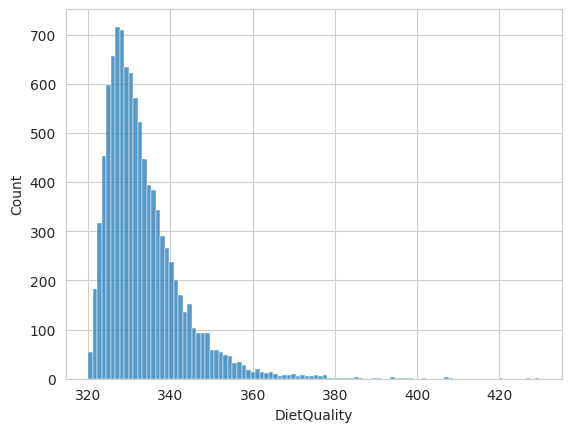

In [ ]:
hist_plot(step=0,product="DietQuality")

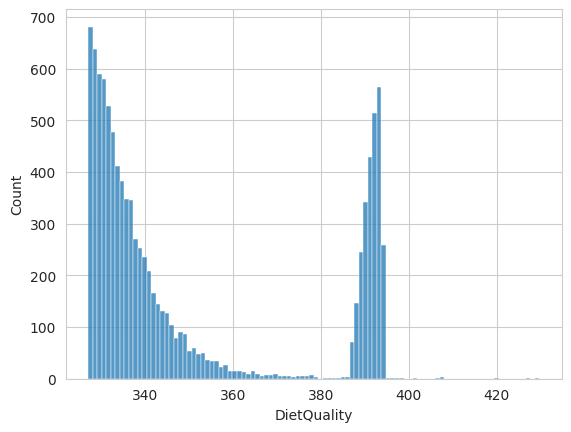

In [ ]:
hist_plot(step=9,product="DietQuality")

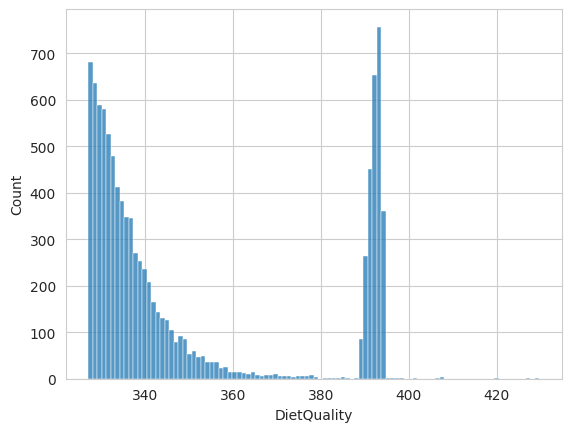

In [ ]:
hist_plot(step=360,product="DietQuality")

In [ ]:
 piplyr(a_df).filter("Income<20000").to_df


,Step,AgentID,Income,EnergyIntake,DietQuality,GrainsConsumption,FVegConsumption,ProteinConsumption,MilkConsumption,FatsConsumption,diet_q
99,0,101,14571.0,3826.439567,321.201915,606.360099,34.513786,386.668696,233.745905,0,321
102,0,104,11141.0,3823.080129,320.414026,606.004035,32.716312,386.310136,234.112178,0,320
118,0,120,19514.0,3831.28088,322.337347,606.873226,37.10414,387.18542,233.218067,0,322
168,0,170,18908.0,3830.687347,322.198146,606.810318,36.786569,387.122071,233.282779,0,322
238,0,240,16435.0,3828.265221,321.630085,606.553599,35.490606,386.863552,233.546858,0,321
...,...,...,...,...,...,...,...,...,...,...,...
9825,9,827,14598.0,3958.562349,387.520599,608.280831,178.687859,397.141571,250.80071,0.132089,387
9894,9,896,17308.0,3962.355152,388.231637,608.568584,180.243956,397.50545,250.527062,0.211677,388
9942,9,944,19179.0,3964.973726,388.722541,608.767249,181.318295,397.756674,250.338134,0.266625,388
9958,9,960,17991.0,3963.31105,388.410839,608.641106,180.636138,397.597158,250.458095,0.231736,388


In [ ]:
piplyr(a_df).filter("AgentID==104").to_df

,Step,AgentID,Income,EnergyIntake,DietQuality,GrainsConsumption,FVegConsumption,ProteinConsumption,MilkConsumption,FatsConsumption,diet_q
102,0,104,11141.0,3823.080129,320.414026,606.004035,32.716312,386.310136,234.112178,0,320
10102,1,104,11169.851785,3950.568731,386.366584,606.892874,176.441674,396.781855,251.249543,0.03841,386
20102,2,104,11198.674726,3953.83242,386.633972,607.924715,176.745376,396.686419,251.144458,0.03232,386
30102,3,104,11227.468851,3953.846257,386.636462,607.923029,176.752814,396.689165,251.141085,0.033104,386
40102,4,104,11256.234189,3953.886378,386.644006,607.926031,176.769337,396.693036,251.138188,0.033949,386
...,...,...,...,...,...,...,...,...,...,...,...
3600102,360,104,19867.57151,3965.939236,388.903568,608.840424,181.714274,397.849433,250.268669,0.286853,388
3610102,361,104,19887.698906,3965.967407,388.908849,608.842561,181.725832,397.852136,250.266637,0.287445,388
3620102,362,104,19907.806179,3965.99555,388.914125,608.844696,181.737378,397.854837,250.264606,0.288035,388
3630102,363,104,19927.893349,3966.023665,388.919396,608.846829,181.748913,397.857534,250.262578,0.288625,388


In [ ]:
import pandas as pd
from plotnine import *
df47= piplyr(a_df).filter("AgentID==104").to_df
# reshape df47 from wide to long format
df47_long = df47.melt(id_vars='Step', value_vars=['GrainsConsumption', 'FVegConsumption', 'ProteinConsumption', 'MilkConsumption', 'FatsConsumption', 'DietQuality'],
                      var_name='Food', value_name='Consumption')

df47_long[["Consumption"]] = df47_long[['Consumption']].astype("int32")

df47_long


,Step,Food,Consumption
0,0,GrainsConsumption,606
1,1,GrainsConsumption,606
2,2,GrainsConsumption,607
3,3,GrainsConsumption,607
4,4,GrainsConsumption,607
...,...,...,...
2185,360,DietQuality,388
2186,361,DietQuality,388
2187,362,DietQuality,388
2188,363,DietQuality,388


/usr/local/lib/python3.10/dist-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


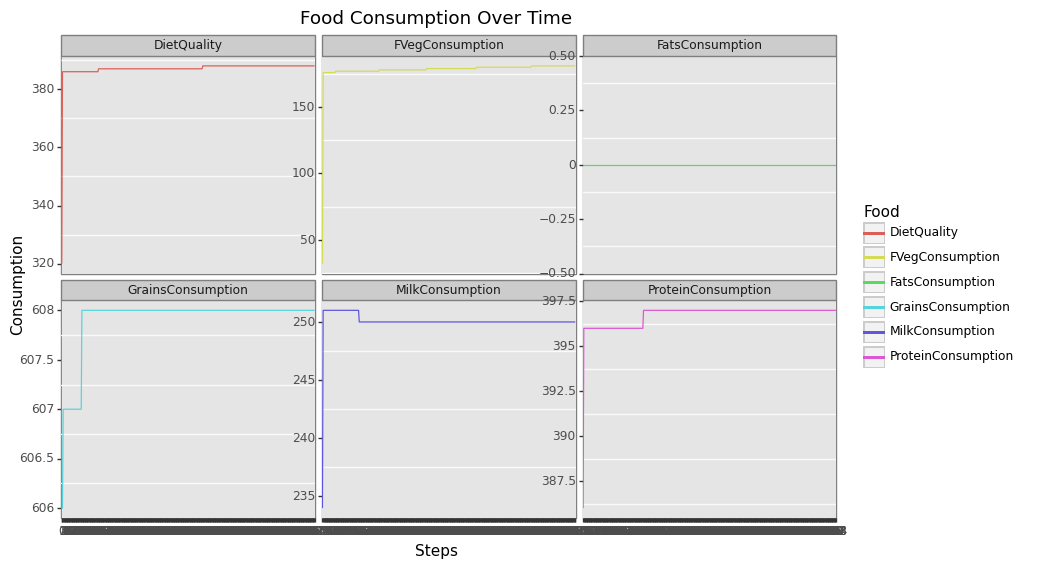

<ggplot: (8747135338722)>

In [ ]:
# create plot
p = (ggplot(df47_long, aes(x='Step', y='Consumption', color='Food'))
     + geom_line(group=1)
     + facet_wrap('~ Food', scales='free_y')
     + labs(title='Food Consumption Over Time', x='Steps', y='Consumption')
     + theme_bw()
     + theme(figure_size=(10, 6)))

p

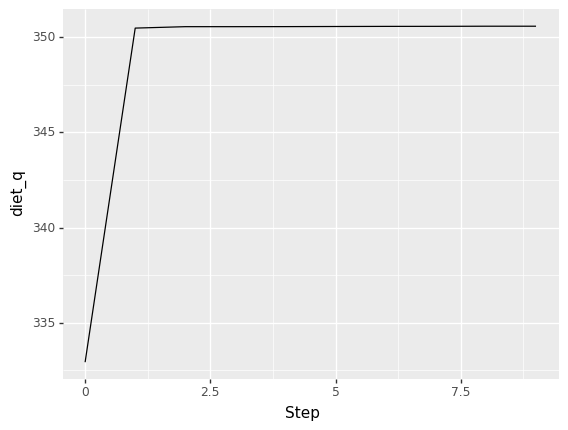

<ggplot: (8785032202120)>

In [ ]:
import numpy as np
from plotnine import ggplot, aes, geom_density, geom_vline, facet_wrap

# Calculate the means
mean_values = a_df.groupby('Step')['diet_q'].mean().reset_index()
median_values = a_df.groupby('Step')['diet_q'].median().reset_index()



ggplot(mean_values,aes("Step","diet_q")) + geom_line()
#ggplot(median_values,aes("Step","diet_q")) + geom_line()


In [ ]:
np.mean(a_df["diet_q"])

3777.8004

In [ ]:
a_df

,Step,AgentID,Income,EnergyIntake,DietQuality,GrainsConsumption,FVegConsumption,ProteinConsumption,diet_q
0,0,2,23124.0,2855.889104,1196.231685,1232.020026,1501.400246,1164.225273,1196
1,0,3,38645.0,4765.860578,1996.57747,2055.727974,2506.894165,1942.247363,1996
2,0,4,123822.0,15247.5074,6388.759215,6576.117887,8024.899162,6211.919909,6388
3,0,5,21883.0,2703.175064,1132.239087,1166.159478,1421.004785,1102.017592,1132
4,0,6,210112.0,25866.116933,10838.333194,11155.575319,13615.007421,10537.383871,10838
...,...,...,...,...,...,...,...,...,...
2495,4,497,110477.0,13605.308487,5700.61963,5867.891448,7160.372627,5542.9743,5700
2496,4,498,51644.0,6882.858853,3198.127815,2318.117696,4543.039068,3057.628831,3198
2497,4,499,62158.0,7659.305543,3209.033524,3303.575726,4030.132263,3120.884913,3209
2498,4,500,106095.0,13066.071646,5474.66027,5635.336315,6876.494375,5323.317525,5474


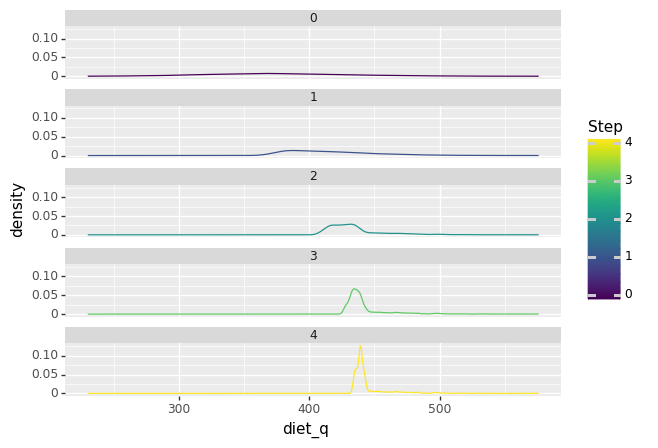

<ggplot: (8742702045413)>

In [ ]:
ggplot(a_df,aes(x="diet_q",color="Step")) + geom_density() + facet_wrap('~Step',scales="Free",ncol=1)

## AIDS

In order to understand how to derive the demand for three different food items based on their price and the constraints of budget and energy intake, we first need to define a few key concepts.

Let's say we have three food items: apples, bananas, and carrots. Each of these items has a certain price and provides a specific amount of energy (measured in calories). The consumer has a limited budget, and also a maximum amount of energy they wish to intake.

The utility function is a key concept in this context. It represents the level of satisfaction or happiness that a consumer gets from consuming different combinations of goods. In our case, it would represent how much a consumer enjoys consuming different combinations of apples, bananas, and carrots.

The choice of a functional form for the utility function can vary depending on the specifics of the problem at hand. A commonly used form in consumer theory is the Cobb-Douglas utility function, which takes the form U(x,y,z) = x^a * y^b * z^c, where x, y, and z are the quantities of apples, bananas, and carrots consumed, respectively, and a, b, and c are parameters that determine the consumer's preferences.

Now, let's consider the constraints. The budget constraint is simply that the total amount of money spent on apples, bananas, and carrots cannot exceed the consumer's budget. If we let P_x, P_y, and P_z represent the prices of apples, bananas, and carrots, respectively, then the budget constraint can be written as P_xx + P_yy + P_z*z <= B, where B is the budget.

The energy intake constraint is similar. Let E_x, E_y, and E_z be the energy content (in calories) of apples, bananas, and carrots, respectively. Then the energy constraint can be written as E_xx + E_yy + E_z*z <= E, where E is the maximum amount of energy the consumer wants to intake.

Given these constraints, the consumer's problem is to choose x, y, and z to maximize their utility while staying within their budget and not exceeding their desired energy intake. This is a standard optimization problem, and can be solved using methods from calculus, such as the method of Lagrange multipliers.

In summary, to derive the demand for the three food items, we would:

Define a utility function, such as the Cobb-Douglas function.
Set up the budget and energy intake constraints.
Use optimization techniques to solve for the quantities x, y, and z that maximize the utility function while satisfying the constraints.


Let's say that:

The price of apples (Px) is $1 per unit, the price of bananas (Py) is $2 per unit, and the price of carrots (Pz) is $3 per unit.

The energy content of apples (Ex) is 100 calories per unit, of bananas (Ey) is 150 calories per unit, and of carrots (Ez) is 200 calories per unit.

The consumer's budget (B) is $50, and their maximum desired energy intake (E) is 3000 calories.

The consumer's preferences are represented by the Cobb-Douglas utility function U(x,y,z) = x^0.5 * y^0.3 * z^0.2, which means that they prefer apples slightly more than bananas and bananas slightly more than carrots.

The consumer's problem is to choose quantities x, y, and z to maximize the utility function

U(x,y,z) = x^0.5 * y^0.3 * z^0.2

subject to the constraints

P_xx + P_yy + P_z*z <= B

and

E_xx + E_yy + E_z*z <= E

This is a constrained optimization problem, and can be solved using the method of Lagrange multipliers. We set up the Lagrangian function

L(x,y,z,λ,μ) = x^0.5 * y^0.3 * z^0.2 + λ*(B - P_xx - P_yy - P_zz) + μ(E - E_xx - E_yy - E_z*z)

where λ and μ are the Lagrange multipliers.

We then take the partial derivatives of L with respect to x, y, z, λ, and μ, and set them equal to zero to find the optimal values.

The solution involves some complex algebra and calculus, and typically requires the use of a software tool for numerical computation. This is because the system of equations that results from the Lagrangian is usually not solvable by hand.

Using a numerical solver, we can find the optimal quantities of apples, bananas, and carrots that the consumer should purchase to maximize their utility while staying within their budget and not exceeding their desired energy intake.